In [31]:
import numpy as np
import matplotlib.pyplot as plt
from dlordinal.datasets import FGNet
from dlordinal.losses import TriangularCrossEntropyLoss
from mapie.conformity_scores import LACConformityScore
from skorch import NeuralNetClassifier
import torch
from torch import nn
from torch.optim import Adam
from torchvision import models
from torchvision.transforms import Compose, ToTensor

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
optimiser_params = {"lr": 1e-3, "bs": 400, "epochs": 5, "s": 2, "c": 0.2, "beta": 0.5}
workers = 3

torch.serialization.add_safe_globals([
    models.ResNet, nn.Conv2d, nn.BatchNorm2d
])

In [32]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        raise Exception("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        raise Exception("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

In [33]:
from torch.utils.data import DataLoader

fgnet_train = FGNet(
    root="./.datasets",
    train=True,
    target_transform=np.array,
    transform=Compose([ToTensor()]),
)
fgnet_test = FGNet(
    root="./.datasets",
    train=False,
    target_transform=np.array,
    transform=Compose([ToTensor()]),
)

X_train, y_train = np.array([x for x, y in iter(fgnet_train)]), np.array([y for x, y in iter(fgnet_train)])
X_test, y_test = np.array([x for x, y in iter(fgnet_test)]), np.array([y for x, y in iter(fgnet_test)])

Files already downloaded and verified
Files already processed and verified
Files already split and verified
Files already downloaded and verified
Files already processed and verified
Files already split and verified


In [45]:
from util import SoftmaxNeuralNetClassifier

num_classes_fgnet = len(fgnet_train.classes)

# Model
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes_fgnet)
model = model.to(device)

loss_fn = TriangularCrossEntropyLoss(num_classes=num_classes_fgnet).to(device)

# Skorch estimator
classifier = SoftmaxNeuralNetClassifier(
    module=model,
    criterion=loss_fn,
    optimizer=Adam,
    lr=1e-3,
    max_epochs=25,
    train_split=None,
    device=device,
)


In [46]:
import torch.nn.functional as F
from mapie.classification import MapieClassifier

lac_cp = MapieClassifier(
    estimator=classifier,
    conformity_score=LACConformityScore(),
    cv='split',
)
lac_cp = lac_cp.fit(X_train, y_train)

  epoch    train_loss      dur
-------  ------------  -------
      1        1.7002  25.0536
      2        1.2153  5.0826
      3        0.7511  5.4537
      4        0.5362  4.4756
      5        0.4327  4.5061
      6        0.3878  4.8117
      7        0.3685  4.6254
      8        0.3576  4.1232
      9        0.3528  4.1210
     10        0.3497  4.2742
     11        0.3479  5.2380
     12        0.3470  4.9081
     13        0.3463  3.5611
     14        0.3459  4.4664
     15        0.3456  4.9071
     16        0.3454  5.1877
     17        0.3452  4.2828
     18        0.3450  20.3216
     19        0.3449  6.9896
     20        0.3448  4.6521
     21        0.3447  4.5971
     22        0.3446  4.3045
     23        0.3445  4.7358
     24        0.3444  4.1739
     25        0.3443  4.6461
  epoch    train_loss     dur
-------  ------------  ------
      1        1.7298  3.6152
      2        1.0100  2.8648
      3        0.6830  3.0830
      4        0.5081  3.2590
      

In [47]:
probas = classifier.predict_proba(X_test[:10])
print(probas.sum(axis=1))

NotInitializedError: This SoftmaxNeuralNetClassifier instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [53]:
from mapie.metrics import classification_mean_width_score, classification_coverage_score

# Maximum allowed error rate
alpha = 0.2

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_set = lac_cp.predict(X_test, alpha=alpha)
mean_width = classification_mean_width_score(y_pred_set[:, :, 0])
coverage = classification_coverage_score(y_test, y_pred_set[:, :, 0])
print(f"Effective coverage: {np.round(coverage, 2)}")
print(f"Mean width: {np.round(mean_width, 2)}")

Effective coverage: 0.87
Mean width: 1.94


/Users/lucakillmaier/miniconda3/envs/conformal-prediction/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/Users/lucakillmaier/miniconda3/envs/conformal-prediction/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


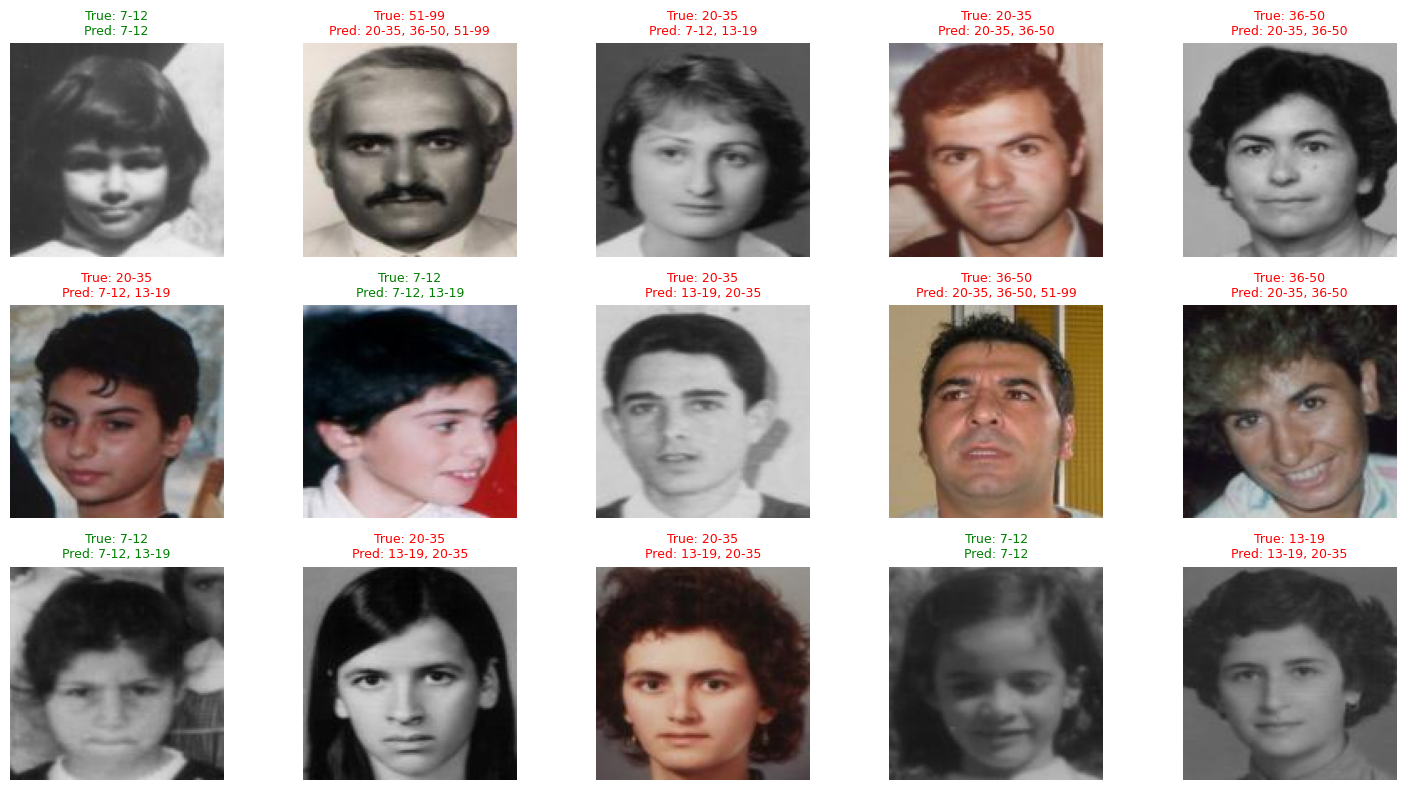

In [58]:
import random

class_names = ['0-6','7-12','13-19','20-35','36-50','51-99']  # Adjust based on your dataset

# Number of samples to visualize
n_samples = 15
indices = random.sample(range(len(X_test)), n_samples)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    image = X_test[idx]  # Image corresponding to X_test[idx]
    true_label = y_test[idx]
    pred_set = y_pred_set[idx]

    is_correct = true_label in pred_set
    color = "green" if is_correct else "red"

    plt.subplot(3, 5, i + 1)
    plt.imshow((np.transpose(image, (1, 2, 0)) * 255).astype("uint8"))  # Adjust if your image format differs
    plt.axis('off')
    plt.title(
        f"True: {class_names[true_label]}\nPred: {', '.join([class_names[iidx] for iidx, p in enumerate(pred_set) if p[0] == True])}",
        color=color,
        fontsize=9
    )

plt.tight_layout()
plt.show()